# Homework 2: A/B Hypothesis Testing and Regression

## Due Tuesday, May 29, start of class

### Jake Pitkin

## Part 1 : A/B Hypothesis Testing

Null hypothesis: Ad A and ad B are the same. That is a_prob - b_prob = 0.

In [29]:
import scipy as sc
from scipy.stats import norm

a_views = 1000
a_clicks = 500
a_prob = a_clicks/a_views

b_views = 1000
b_clicks = 550
b_prob = b_clicks/b_views

p_hat = (a_clicks + b_clicks)/(a_views + b_views)
q_hat = 1 - p_hat
print("p_hat:", p_hat)
print("q_hat:", q_hat)

z = (a_prob - b_prob) / sc.sqrt(p_hat*q_hat*(1/a_views + 1/b_views))
print("Z:", z)

p_value = norm.cdf(z)
print("p-value:", p_value)

if p_value < 0.01:
    print("Null hypothesis rejected with 1% significance level.")
if p_value < 0.05:
    print("Null hypothesis rejected with 5% significance level.")

p_hat: 0.525
q_hat: 0.475
Z: -2.2388683142
p-value: 0.0125822428502
Null hypothesis rejected with 5% significance level.


## Part 2: Regression of real estate data

### Task 1: Import the data

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

real_estate_one = pd.read_csv("realEstate1.csv", sep=',')
real_estate_two = pd.read_csv("realEstate2.csv", sep=',')
df = pd.concat([real_estate_one, real_estate_two], ignore_index=True)

### Task 2: Clean the data

In [110]:
# Remove houses that don't have a list price between $200,000 and $1,000,000
df = df.drop(df[(df['LstPrice'] <= 200000) | (df['LstPrice'] >= 1000000)].index)

# Only keep attributes we are interested in
df = df[['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'LstPrice', 'Patio', 
         'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']].copy()

# Correct the data types for the attributes we are interested in
if df['TotSqf'].dtype == 'object':
    df['TotSqf'] = df['TotSqf'].str.replace(',','').astype(int)

# Add numerical value for Property Type category
# 1 for a Single Family home and 0 otherwise
df['Prop_Type_num'] = df['PropType'].map({'Single Family' : 1, 'Condo' : 0, 'Townhouse' : 0})

# Drop listing with Longitude of 0
df = df.drop(df[df['Longitude'] == 0.0].index)

# Drop listings with unreasonably large Taxes
df = df.drop(df[df['Taxes'] > 90000].index)

Int64Index([266], dtype='int64')


### Task 3: Exploratory data analysis

The dataset contains 257 elements.
It contains 16 different variables.


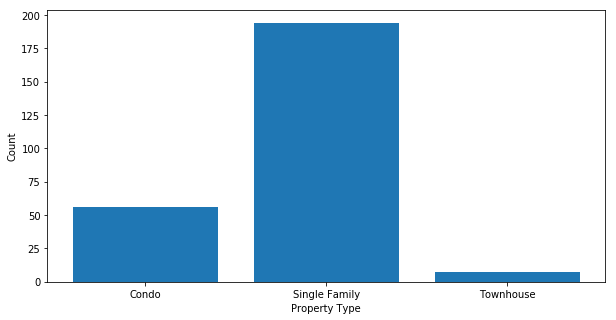

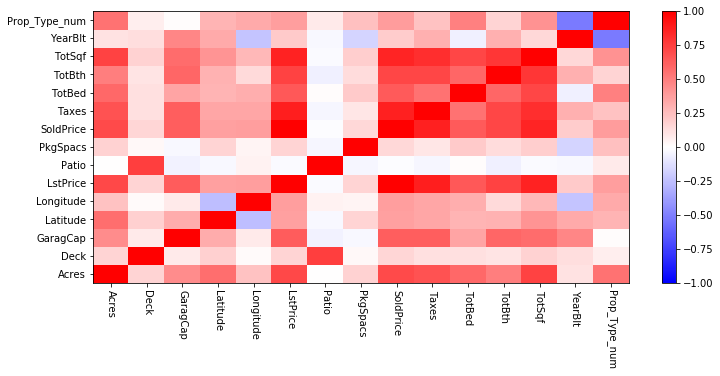

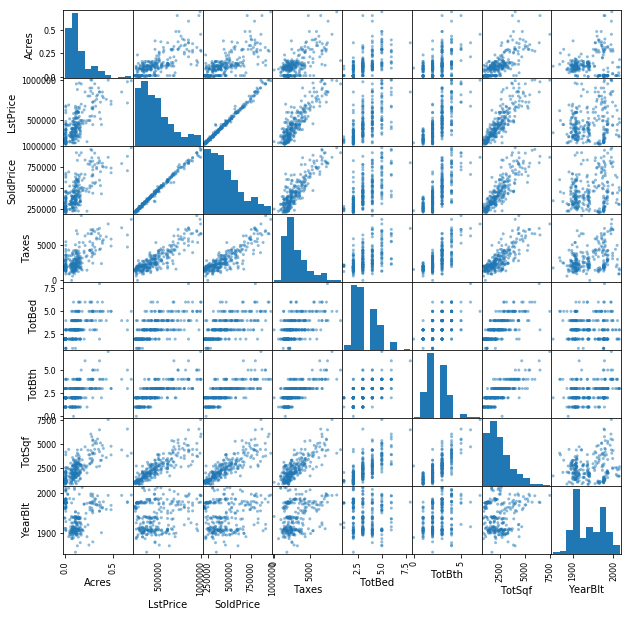

In [35]:
# Description of the dataset
print("The dataset contains {} elements.".format(len(df)))
print("It contains {} different variables.".format(len(df.columns)))

%matplotlib inline

# Bar chart of the different property types
plt.figure(figsize=(10, 5))
plt.xlabel("Property Type")
plt.ylabel("Count")
plt.bar(df['PropType'].unique(), df['PropType'].value_counts());

# Correlation matrix heat map
plt.figure(figsize=(12, 5))
heatmap = plt.pcolor(df.corr(), cmap=plt.cm.bwr, vmin=-1, vmax=1)
labels = np.delete(df.columns.values, np.argwhere(df.columns.values == "PropType"))
plt.xticks(np.arange(0.5, 15, step=1), labels, rotation=270)
plt.yticks(np.arange(0.5, 15, step=1), labels)
plt.colorbar(heatmap);

# Scatterplot matrix of the correlations
sub_df = df[['Acres', 'LstPrice', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']].copy()
pd.plotting.scatter_matrix(sub_df, figsize=(10, 10), diagonal='hist');

### Task 4: Geospatial plot

            Acres        Deck    GaragCap    Latitude   Longitude  \
count  257.000000  257.000000  257.000000  257.000000  257.000000   
mean     0.131051    0.750973    1.276265   40.777555 -111.875749   
std      0.123753    1.246969    0.975051    0.005825    0.013946   
min      0.000000    0.000000    0.000000   40.769424 -111.913645   
25%      0.050000    0.000000    0.000000   40.772489 -111.886688   
50%      0.110000    1.000000    1.000000   40.775852 -111.874094   
75%      0.160000    1.000000    2.000000   40.782180 -111.866018   
max      0.690000   16.000000    5.000000   40.791059 -111.843083   

            LstPrice       Patio    PkgSpacs      SoldPrice        Taxes  \
count     257.000000  257.000000  257.000000     257.000000   257.000000   
mean   463404.525292    0.832685    1.046693  450866.692607  3024.774319   
std    197317.157047    3.397957    1.587844  187524.462691  1664.202506   
min    205000.000000    0.000000    0.000000  205000.000000     1.000000  

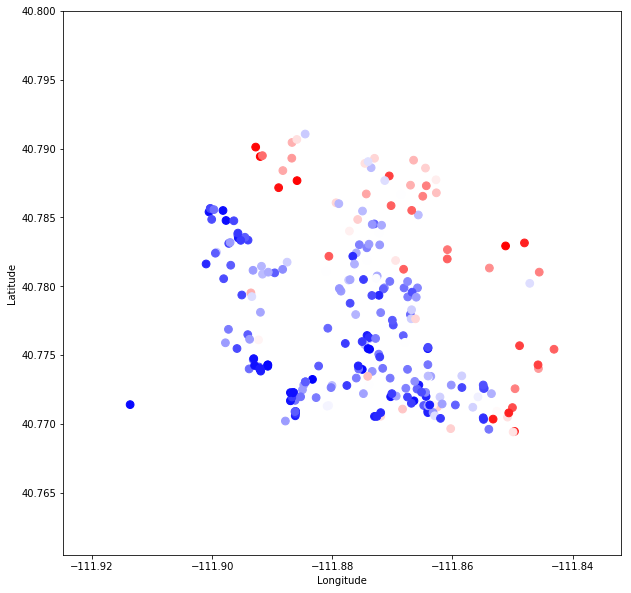

In [46]:
print(df.describe())
print(df.shape)
print(df.corr())

# Geospatial plot with list price encoded with color
plt.figure(figsize=(10, 10))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.scatter(x=df['Longitude'], y=df['Latitude'], c=df['LstPrice'], cmap='bwr', s=60);

### Task 5: Simple Linear Regression

R-squared: 0.98998206559
Beta: 12672.0997162
List Price Beta: 0.945598432848


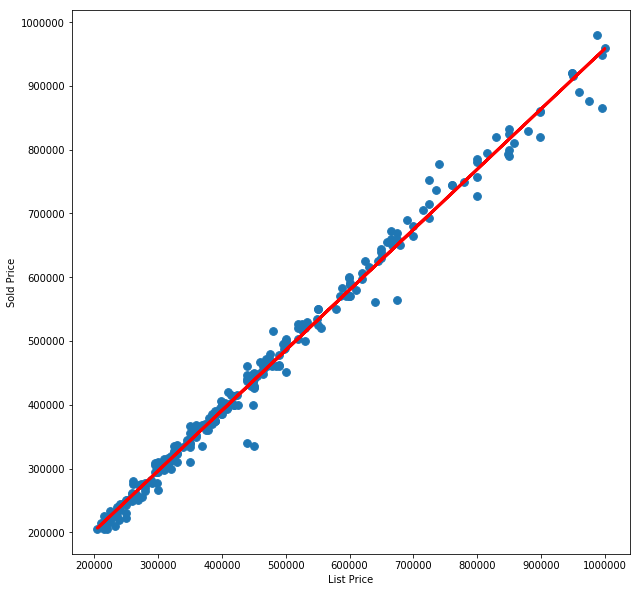

In [11]:
import statsmodels.formula.api as sm

regression = sm.ols(formula="SoldPrice ~ LstPrice", data=df).fit()
par = dict(regression.params)
print("R-squared:", regression.rsquared)
print("Beta:", par['Intercept'])
print("List Price Beta:", par['LstPrice'])

# Scatterplot of list price vs sold price
plt.figure(figsize=(10, 10))
plt.xlabel("List Price")
plt.ylabel("Sold Price")
plt.scatter(x=df['LstPrice'], y=df['SoldPrice'], s=60)
plt.plot(df['LstPrice'],regression.predict(),c='r',linewidth=3);

### Task 6: Multilinear Regression

In [52]:
multi_regression = sm.ols(formula="SoldPrice ~ Taxes + TotSqf + Acres + GaragCap", data=df).fit()
multi_regression.summary()
par = dict(multi_regression.params)
print("R-squared:", multi_regression.rsquared)

# Often the price per square foot for a house is advertised. 
# Is this what the coefficient for TotSqf is measuring? 
# Provide an interpretation for the coefficient for TotSqf.
print("Total Square Ft Beta:", par['TotSqf'])

# Estimate the value that each Garage space adds to a house.
print("Garage Space Beta:", par['GaragCap'])

# Does latitude or longitude have an impact on house price? Explain.
print("No they don't.")

# If we wanted to start a 'house flipping' company, 
# we'd have to be able to do a better job of predicting the sold price 
# than the list price does. How does your model compare?
print("It does a worse job.")


R-squared: 0.833125218366
Total Square Ft Beta: 56.7344024209
Garage Space Beta: 16867.2269442
No they don't.
It does a worse job.


### Task 7: Incorporating a categorical variable

R-squared: 0.146971612758
R-squared: 0.733527073041


,Acres,Deck,GaragCap,Latitude,Longitude,LstPrice,Patio,PkgSpacs,SoldPrice,Taxes,TotBed,TotBth,TotSqf,YearBlt,Prop_Type_num
Acres,1.000000,0.165732,0.447886,0.568249,0.235933,0.716560,0.005157,0.178064,0.709380,0.678446,0.588819,0.504789,0.738043,0.110440,0.550447
Deck,0.165732,1.000000,0.079294,0.184221,0.019710,0.165510,0.753466,0.027597,0.161274,0.119304,0.117856,0.107399,0.173308,0.130219,0.067675
GaragCap,0.447886,0.079294,1.000000,0.323426,0.079707,0.636116,-0.048481,-0.026026,0.626073,0.629634,0.352746,0.597674,0.570661,0.470059,0.013056
Latitude,0.568249,0.184221,0.323426,1.000000,-0.252985,0.371438,-0.026625,0.169701,0.374229,0.344140,0.292322,0.299270,0.415019,0.333459,0.293326
Longitude,0.235933,0.019710,0.079707,-0.252985,1.000000,0.375739,0.047546,0.044034,0.378518,0.345215,0.315474,0.141285,0.275745,-0.231580,0.332640
LstPrice,0.716560,0.165510,0.636116,0.371438,0.375739,1.000000,-0.017352,0.164530,0.994978,0.878184,0.649052,0.738358,0.866691,0.207930,0.375962
Patio,0.005157,0.753466,-0.048481,-0.026625,0.047546,-0.017352,1.000000,-0.033298,-0.013058,-0.038108,0.012585,-0.057990,-0.017008,-0.026131,0.078574
PkgSpacs,0.178064,0.027597,-0.026026,0.169701,0.044034,0.164530,-0.033298,1.000000,0.149729,0.094513,0.204235,0.138750,0.188713,-0.170480,0.245102
SoldPrice,0.709380,0.161274,0.626073,0.374229,0.378518,0.994978,-0.013058,0.149729,1.000000,0.873635,0.644520,0.725855,0.856134,0.202465,0.383369
Taxes,0.678446,0.119304,0.629634,0.344140,0.345215,0.878184,-0.038108,0.094513,0.873635,1.000000,0.547986,0.726250,0.814223,0.307737,0.240413


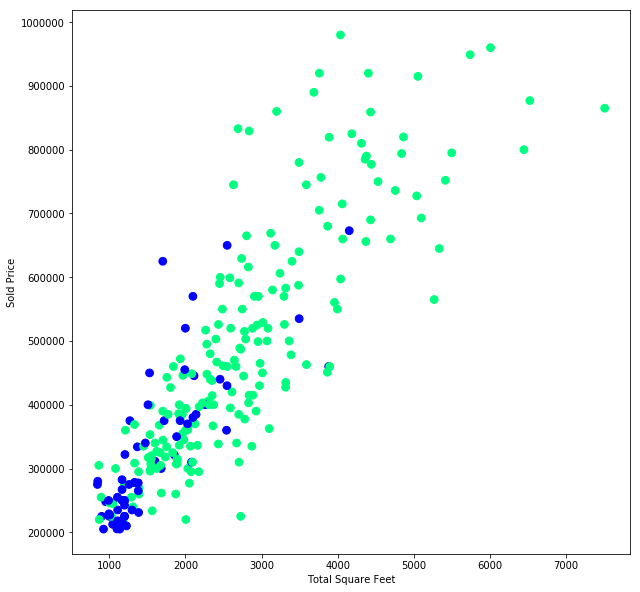

In [25]:
regression_one = sm.ols(formula="SoldPrice ~ Prop_Type_num", data=df).fit()
print("R-squared:", regression_one.rsquared)

regression_two = sm.ols(formula="SoldPrice ~ Prop_Type_num + TotSqf", data=df).fit()
regression_two.summary()
print("R-squared:", regression_two.rsquared)

plt.figure(figsize=(10, 10))
plt.xlabel("Total Square Feet")
plt.ylabel("Sold Price")
plt.scatter(x=df['TotSqf'], y=df['SoldPrice'], c=df['Prop_Type_num'], cmap='winter', s=60);

df.corr()